# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

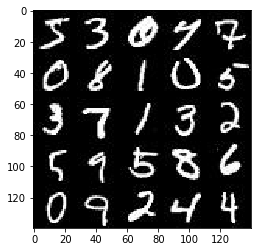

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

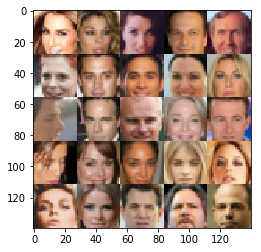

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0-rc1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
## Kernel and Alpha Hyperparamers and setting a random seed
import numpy as np
kernel_size = 5
alpha = 0.2   #0.2 happens to be the TF default anyway
np.random.seed(42)

In [19]:
## Using similar method as in the DCGAN exercise for house numbers.
# Batch Normalization on the 2nd and 3rd hidden layers
# Leaky relu
# setting an initial filters parameter to make experimentation easier.
# Some inspiration taken from byanofsky at 
# https://github.com/byanofsky/gan-face-generation/blob/master/dlnd_face_generation.ipynb
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    filters = 64
    keep = 0.7
    kernel_initializer = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, filters, kernel_size, strides=2, padding='same', activation=None,
                             kernel_initializer=kernel_initializer)
        x1 = tf.nn.leaky_relu(x1, alpha=alpha)
        x1 = tf.nn.dropout(x1, keep)
        
        x2 = tf.layers.conv2d(x1, filters*2, kernel_size, strides=1, padding='same', activation=None,
                             kernel_initializer=kernel_initializer)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.nn.leaky_relu(x2, alpha=alpha)
        x2 = tf.nn.dropout(x2, keep)
        
        x3 = tf.layers.conv2d(x2, filters*4, kernel_size, strides=2, padding='same', activation=None,
                             kernel_initializer=kernel_initializer)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.leaky_relu(x3, alpha=alpha)
        x3 = tf.nn.dropout(x3, keep)
        
        #filters*8*4*4
        flat_x = tf.reshape(x3, (-1,filters*8*7*7))
        logits = tf.layers.dense(flat_x,1)
        output = tf.nn.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
## Using similar method as in the DCGAN exercise for house numbers.
# Batch Normalization on the all hidden convolution layers
# Leaky relu
# Some inspiration taken from byanofsky at 
# https://github.com/byanofsky/gan-face-generation/blob/master/dlnd_face_generation.ipynb
def generator(z, out_channel_dim, is_train=True):    #reuse = NOT is_train
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_initializer = tf.contrib.layers.xavier_initializer()
    with tf.variable_scope('generator', reuse=not is_train):
    # TODO: Implement Function
        # First fully connected layer
        x1 = tf.contrib.layers.fully_connected(z, 7*7*256, activation_fn=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.nn.leaky_relu(x1, alpha=alpha)
        # Output is 7 x 7 x 512
        #print('x1 dense',x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, kernel_size, strides=2, padding='same', activation=None,
                                       kernel_initializer=kernel_initializer)
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.nn.leaky_relu(x2, alpha=alpha)
        # Output is 14 x 14 x 256
        #print('x2 conv2d',x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, kernel_size, strides=2, padding='same', activation=None,
                                       kernel_initializer=kernel_initializer)
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.nn.leaky_relu(x3, alpha=alpha)
        # Output is 28 x 28 x 128
        #print('x3 conv2d',x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same',activation=None,
                                            kernel_initializer=kernel_initializer)
        #print('logits',logits)
        # Output s/b 28 x 28 x out_channel_dim
        
        output = tf.tanh(logits)    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
# Using standard loss formulas from DCGAN project
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    #Make real labels 0.9 to help model train
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, name='d_Adam').minimize(d_loss,var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, name='g_Adam').minimize(g_loss,var_list=g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
losses = []
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    global losses
    print_rate = 25 #Number of steps before updating loss 
    sample_rate = 150 #Number of steps before updating sample pictures
    steps = 0
    
    #Create Networks
    input_real, input_z, input_lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    total_steps = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #Double size of batch_images
                batch_images *= 2
                #Get batch of noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})

                if steps % print_rate == 0:
                    # At print_rate interval, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Step {}/{} Epoch {}/{}...".format(steps, total_steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % sample_rate == 0:
                    show_generator_output(sess, 20, input_z, out_channel_dim, data_image_mode)
        print('Final Samples:')
        show_generator_output(sess, 20, input_z, out_channel_dim, data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 25/1875 Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 2.9893
Step 50/1875 Epoch 1/2... Discriminator Loss: 2.3333... Generator Loss: 0.4950
Step 75/1875 Epoch 1/2... Discriminator Loss: 0.4929... Generator Loss: 3.0072
Step 100/1875 Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 1.2126
Step 125/1875 Epoch 1/2... Discriminator Loss: 2.8491... Generator Loss: 0.2183
Step 150/1875 Epoch 1/2... Discriminator Loss: 1.8457... Generator Loss: 1.1167


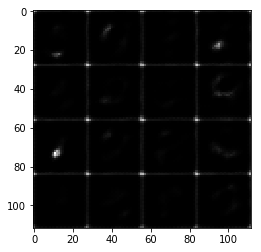

Step 175/1875 Epoch 1/2... Discriminator Loss: 2.0370... Generator Loss: 0.5942
Step 200/1875 Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 1.6762
Step 225/1875 Epoch 1/2... Discriminator Loss: 2.3123... Generator Loss: 0.2759
Step 250/1875 Epoch 1/2... Discriminator Loss: 1.7400... Generator Loss: 1.3763
Step 275/1875 Epoch 1/2... Discriminator Loss: 2.3528... Generator Loss: 0.2700
Step 300/1875 Epoch 1/2... Discriminator Loss: 1.6514... Generator Loss: 0.7404


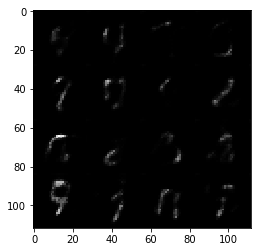

Step 325/1875 Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.9129
Step 350/1875 Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 1.3679
Step 375/1875 Epoch 1/2... Discriminator Loss: 1.6056... Generator Loss: 2.1664
Step 400/1875 Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.4905
Step 425/1875 Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 0.9578
Step 450/1875 Epoch 1/2... Discriminator Loss: 1.2628... Generator Loss: 2.1512


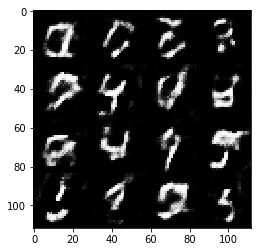

Step 475/1875 Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.8307
Step 500/1875 Epoch 1/2... Discriminator Loss: 2.4648... Generator Loss: 0.2361
Step 525/1875 Epoch 1/2... Discriminator Loss: 2.2507... Generator Loss: 0.3272
Step 550/1875 Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 1.1527
Step 575/1875 Epoch 1/2... Discriminator Loss: 1.6467... Generator Loss: 0.6260
Step 600/1875 Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 1.2087


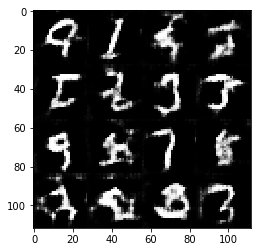

Step 625/1875 Epoch 1/2... Discriminator Loss: 1.6874... Generator Loss: 1.2284
Step 650/1875 Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 1.7442
Step 675/1875 Epoch 1/2... Discriminator Loss: 1.8545... Generator Loss: 0.5992
Step 700/1875 Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 1.6661
Step 725/1875 Epoch 1/2... Discriminator Loss: 1.1241... Generator Loss: 0.7402
Step 750/1875 Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 1.5784


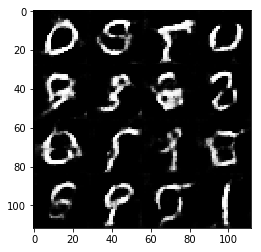

Step 775/1875 Epoch 1/2... Discriminator Loss: 1.7474... Generator Loss: 0.4846
Step 800/1875 Epoch 1/2... Discriminator Loss: 2.4018... Generator Loss: 0.2013
Step 825/1875 Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 1.5135
Step 850/1875 Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.1066
Step 875/1875 Epoch 1/2... Discriminator Loss: 1.5849... Generator Loss: 0.6389
Step 900/1875 Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 1.0198


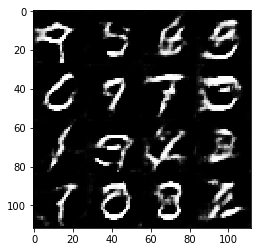

Step 925/1875 Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 0.3816
Step 950/1875 Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 0.8533
Step 975/1875 Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.3291
Step 1000/1875 Epoch 1/2... Discriminator Loss: 1.7179... Generator Loss: 0.6687
Step 1025/1875 Epoch 1/2... Discriminator Loss: 1.7605... Generator Loss: 1.3436
Step 1050/1875 Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 1.4381


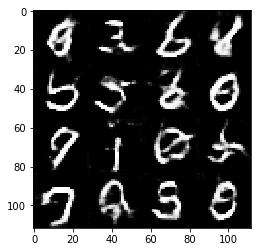

Step 1075/1875 Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.8334
Step 1100/1875 Epoch 1/2... Discriminator Loss: 1.5181... Generator Loss: 1.1978
Step 1125/1875 Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.6582
Step 1150/1875 Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 0.9674
Step 1175/1875 Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 1.2489
Step 1200/1875 Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 2.2188


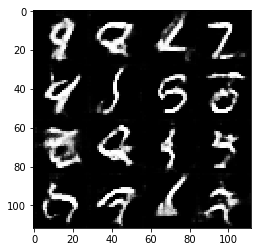

Step 1225/1875 Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 1.1092
Step 1250/1875 Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 1.7808
Step 1275/1875 Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.5730
Step 1300/1875 Epoch 1/2... Discriminator Loss: 1.5490... Generator Loss: 0.3507
Step 1325/1875 Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.6771
Step 1350/1875 Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.6831


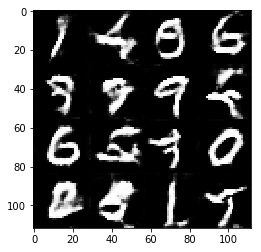

Step 1375/1875 Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 1.8433
Step 1400/1875 Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 0.8143
Step 1425/1875 Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.8771
Step 1450/1875 Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.7286
Step 1475/1875 Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 1.2173
Step 1500/1875 Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.7253


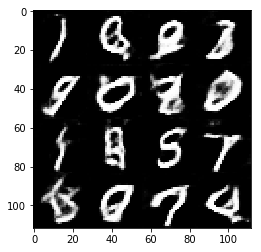

Step 1525/1875 Epoch 1/2... Discriminator Loss: 1.6243... Generator Loss: 1.3808
Step 1550/1875 Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.8873
Step 1575/1875 Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 1.0461
Step 1600/1875 Epoch 1/2... Discriminator Loss: 2.0969... Generator Loss: 0.3391
Step 1625/1875 Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.8613
Step 1650/1875 Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.9256


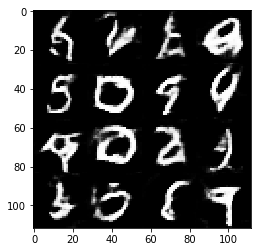

Step 1675/1875 Epoch 1/2... Discriminator Loss: 1.6143... Generator Loss: 0.6365
Step 1700/1875 Epoch 1/2... Discriminator Loss: 1.6347... Generator Loss: 0.5320
Step 1725/1875 Epoch 1/2... Discriminator Loss: 1.8844... Generator Loss: 0.7326
Step 1750/1875 Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 1.9568
Step 1775/1875 Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.4924
Step 1800/1875 Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 1.1060


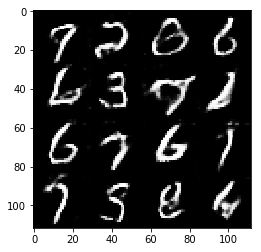

Step 1825/1875 Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 1.4998
Step 1850/1875 Epoch 1/2... Discriminator Loss: 1.9683... Generator Loss: 0.3715
Step 1875/1875 Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.9996
Step 25/1875 Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 1.0167
Step 50/1875 Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 1.2246
Step 75/1875 Epoch 2/2... Discriminator Loss: 1.6424... Generator Loss: 2.1204
Step 100/1875 Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 1.2636
Step 125/1875 Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 1.6460
Step 150/1875 Epoch 2/2... Discriminator Loss: 1.9107... Generator Loss: 0.5344


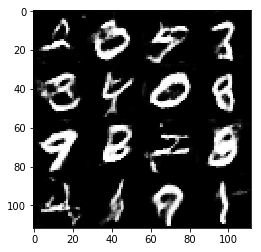

Step 175/1875 Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 1.7445
Step 200/1875 Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 1.3735
Step 225/1875 Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 1.8591
Step 250/1875 Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.3374
Step 275/1875 Epoch 2/2... Discriminator Loss: 2.1563... Generator Loss: 0.3730
Step 300/1875 Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 1.3616


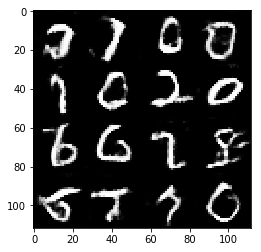

Step 325/1875 Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 1.9946
Step 350/1875 Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 1.7601
Step 375/1875 Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 1.2124
Step 400/1875 Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 1.6264
Step 425/1875 Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 1.4568
Step 450/1875 Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.4030


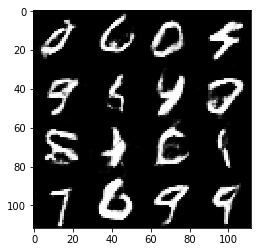

Step 475/1875 Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 2.6494
Step 500/1875 Epoch 2/2... Discriminator Loss: 1.6657... Generator Loss: 0.8065
Step 525/1875 Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 2.4458
Step 550/1875 Epoch 2/2... Discriminator Loss: 1.3041... Generator Loss: 2.3385
Step 575/1875 Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 1.2677
Step 600/1875 Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 0.9663


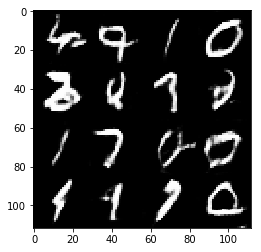

Step 625/1875 Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 0.4954
Step 650/1875 Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 1.7933
Step 675/1875 Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.8367
Step 700/1875 Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 1.4232
Step 725/1875 Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 1.5484
Step 750/1875 Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 2.4660


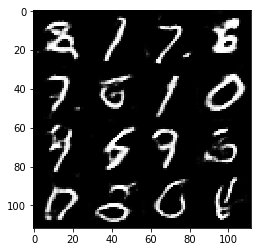

Step 775/1875 Epoch 2/2... Discriminator Loss: 1.6167... Generator Loss: 1.1865
Step 800/1875 Epoch 2/2... Discriminator Loss: 2.2899... Generator Loss: 0.2184
Step 825/1875 Epoch 2/2... Discriminator Loss: 1.3668... Generator Loss: 0.9007
Step 850/1875 Epoch 2/2... Discriminator Loss: 1.2897... Generator Loss: 2.0022
Step 875/1875 Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 2.4527
Step 900/1875 Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.7678


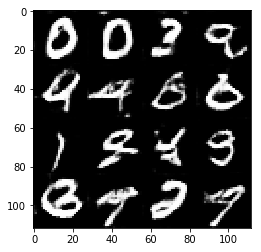

Step 925/1875 Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.9331
Step 950/1875 Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.9538
Step 975/1875 Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.8126
Step 1000/1875 Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.0359
Step 1025/1875 Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 1.2295
Step 1050/1875 Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 2.0062


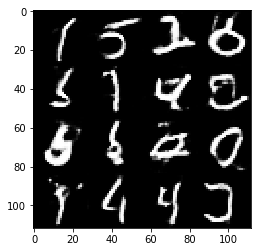

Step 1075/1875 Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 1.2421
Step 1100/1875 Epoch 2/2... Discriminator Loss: 1.1615... Generator Loss: 1.1521
Step 1125/1875 Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 2.5478
Step 1150/1875 Epoch 2/2... Discriminator Loss: 1.4435... Generator Loss: 1.2018
Step 1175/1875 Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.1013
Step 1200/1875 Epoch 2/2... Discriminator Loss: 1.7597... Generator Loss: 0.5665


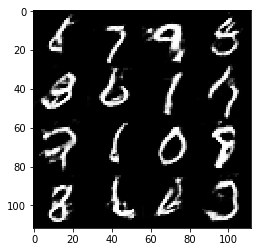

Step 1225/1875 Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.4687
Step 1250/1875 Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.9652
Step 1275/1875 Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.6477
Step 1300/1875 Epoch 2/2... Discriminator Loss: 1.1684... Generator Loss: 1.0472
Step 1325/1875 Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 2.1730
Step 1350/1875 Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.3304


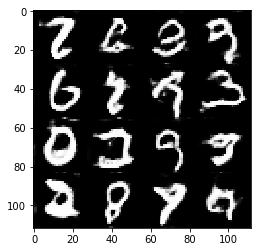

Step 1375/1875 Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 1.5233
Step 1400/1875 Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 1.4811
Step 1425/1875 Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 2.2233
Step 1450/1875 Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 1.0436
Step 1475/1875 Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 1.8838
Step 1500/1875 Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 1.8056


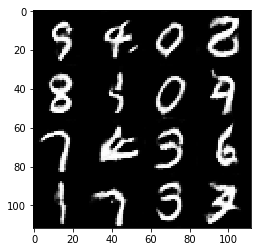

Step 1525/1875 Epoch 2/2... Discriminator Loss: 1.0977... Generator Loss: 1.3112
Step 1550/1875 Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 1.1987
Step 1575/1875 Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 1.1195
Step 1600/1875 Epoch 2/2... Discriminator Loss: 2.0600... Generator Loss: 1.8869
Step 1625/1875 Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 1.8429
Step 1650/1875 Epoch 2/2... Discriminator Loss: 0.8783... Generator Loss: 1.9181


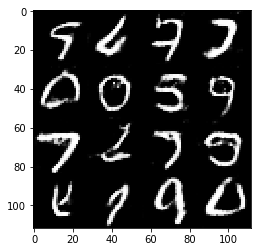

Step 1675/1875 Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.8433
Step 1700/1875 Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 1.0614
Step 1725/1875 Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 1.4205
Step 1750/1875 Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 1.9597
Step 1775/1875 Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 1.0417
Step 1800/1875 Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 1.5330


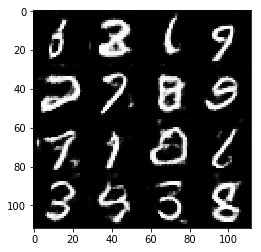

Step 1825/1875 Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.6521
Step 1850/1875 Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 1.3150
Step 1875/1875 Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.3996
Final Samples:


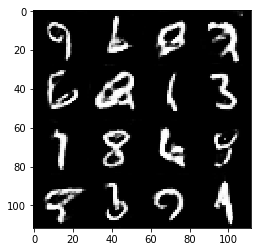

In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005 #0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Plot Losses of Discriminator and Generator
Here we will plot the losses by step increment, not epoch since there are not enough epochs.  This may not reveal anything.

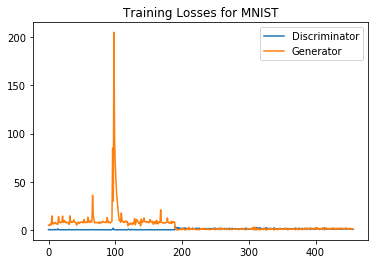

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
nplosses = np.array(losses)
plt.plot(nplosses.T[0], label='Discriminator')
plt.plot(nplosses.T[1], label='Generator')
plt.title("Training Losses for MNIST")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 25/6331 Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.3790
Step 50/6331 Epoch 1/1... Discriminator Loss: 0.6794... Generator Loss: 4.3260
Step 75/6331 Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 0.6977
Step 100/6331 Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 3.0811
Step 125/6331 Epoch 1/1... Discriminator Loss: 3.3511... Generator Loss: 5.9353
Step 150/6331 Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 5.5257


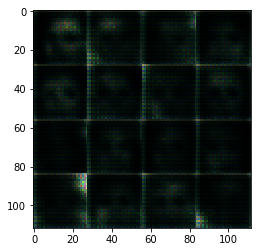

Step 175/6331 Epoch 1/1... Discriminator Loss: 3.7735... Generator Loss: 10.9762
Step 200/6331 Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 5.3100
Step 225/6331 Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 2.0209
Step 250/6331 Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.5945
Step 275/6331 Epoch 1/1... Discriminator Loss: 0.7930... Generator Loss: 1.6488
Step 300/6331 Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 1.3951


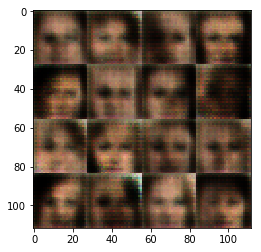

Step 325/6331 Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.1930
Step 350/6331 Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 2.0049
Step 375/6331 Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.7050
Step 400/6331 Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.7218
Step 425/6331 Epoch 1/1... Discriminator Loss: 1.7718... Generator Loss: 0.5066
Step 450/6331 Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.5113


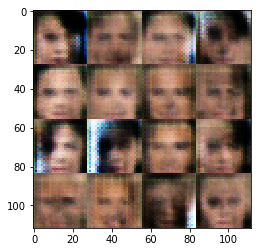

Step 475/6331 Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 1.2867
Step 500/6331 Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6001
Step 525/6331 Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.4275
Step 550/6331 Epoch 1/1... Discriminator Loss: 1.9870... Generator Loss: 3.7721
Step 575/6331 Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 1.0857
Step 600/6331 Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 3.7365


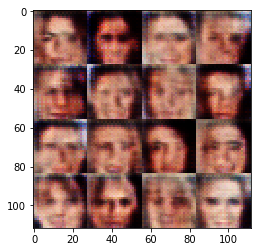

Step 625/6331 Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 3.4160
Step 650/6331 Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.8561
Step 675/6331 Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 1.0244
Step 700/6331 Epoch 1/1... Discriminator Loss: 1.6720... Generator Loss: 0.8275
Step 725/6331 Epoch 1/1... Discriminator Loss: 1.6686... Generator Loss: 3.1150
Step 750/6331 Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.0047


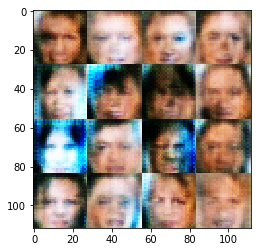

Step 775/6331 Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 1.5192
Step 800/6331 Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.5904
Step 825/6331 Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 2.7159
Step 850/6331 Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 1.5745
Step 875/6331 Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 1.6702
Step 900/6331 Epoch 1/1... Discriminator Loss: 1.7867... Generator Loss: 0.3459


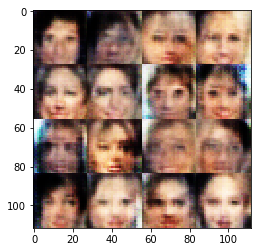

Step 925/6331 Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.3268
Step 950/6331 Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 1.0777
Step 975/6331 Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6730
Step 1000/6331 Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7021
Step 1025/6331 Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 1.1126
Step 1050/6331 Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 1.0126


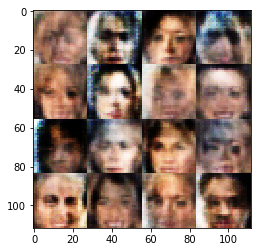

Step 1075/6331 Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6372
Step 1100/6331 Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 1.1029
Step 1125/6331 Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.9805
Step 1150/6331 Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 2.6040
Step 1175/6331 Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 1.3647
Step 1200/6331 Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8539


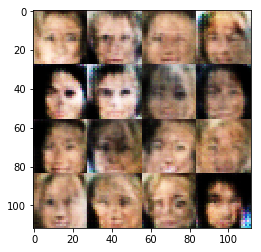

Step 1225/6331 Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.1776
Step 1250/6331 Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.1213
Step 1275/6331 Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 1.0412
Step 1300/6331 Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.5245
Step 1325/6331 Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.3870
Step 1350/6331 Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6408


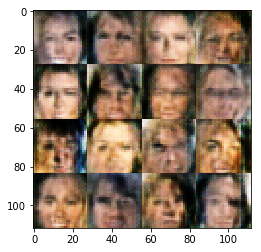

Step 1375/6331 Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.7386
Step 1400/6331 Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 1.2225
Step 1425/6331 Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.0785
Step 1450/6331 Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.9933
Step 1475/6331 Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.9209
Step 1500/6331 Epoch 1/1... Discriminator Loss: 1.5916... Generator Loss: 1.2254


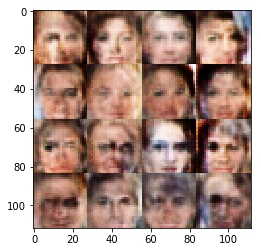

Step 1525/6331 Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.1176
Step 1550/6331 Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 1.1828
Step 1575/6331 Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8526
Step 1600/6331 Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.5978
Step 1625/6331 Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6244
Step 1650/6331 Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5820


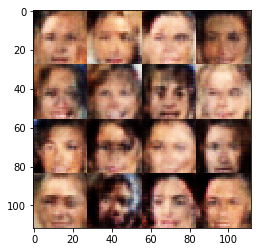

Step 1675/6331 Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.2137
Step 1700/6331 Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 1.0983
Step 1725/6331 Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 1.0831
Step 1750/6331 Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.9007
Step 1775/6331 Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7916
Step 1800/6331 Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.0684


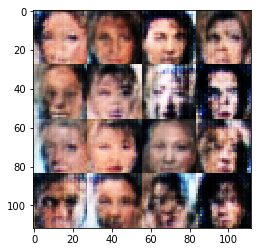

Step 1825/6331 Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.2153
Step 1850/6331 Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.0036
Step 1875/6331 Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.1920
Step 1900/6331 Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.9125
Step 1925/6331 Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7326
Step 1950/6331 Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.8443


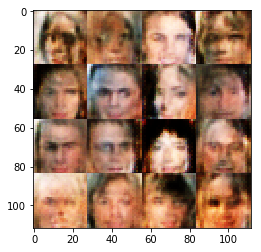

Step 1975/6331 Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.6116
Step 2000/6331 Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 1.0039
Step 2025/6331 Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 2.0006
Step 2050/6331 Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7093
Step 2075/6331 Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.3306
Step 2100/6331 Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 1.2947


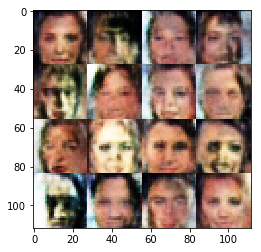

Step 2125/6331 Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.4611
Step 2150/6331 Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.1101
Step 2175/6331 Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9763
Step 2200/6331 Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8582
Step 2225/6331 Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.8815
Step 2250/6331 Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7306


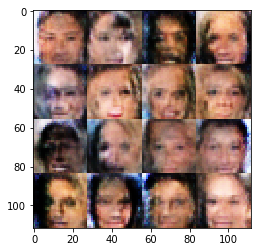

Step 2275/6331 Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.8128
Step 2300/6331 Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6138
Step 2325/6331 Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 1.2839
Step 2350/6331 Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6906
Step 2375/6331 Epoch 1/1... Discriminator Loss: 1.8022... Generator Loss: 0.7665
Step 2400/6331 Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7465


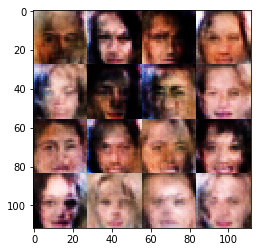

Step 2425/6331 Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.6450
Step 2450/6331 Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.8417
Step 2475/6331 Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 0.9897
Step 2500/6331 Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9600
Step 2525/6331 Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8254
Step 2550/6331 Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 1.3500


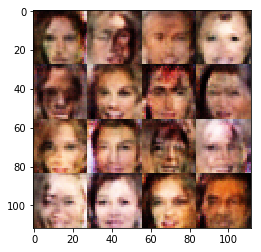

Step 2575/6331 Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7486
Step 2600/6331 Epoch 1/1... Discriminator Loss: 2.1432... Generator Loss: 0.2129
Step 2625/6331 Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.0602
Step 2650/6331 Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.4967
Step 2675/6331 Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.8735
Step 2700/6331 Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8670


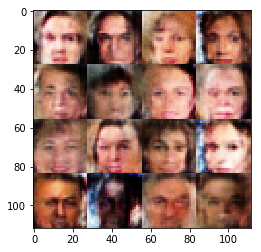

Step 2725/6331 Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.0173
Step 2750/6331 Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 1.2563
Step 2775/6331 Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7733
Step 2800/6331 Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 1.0564
Step 2825/6331 Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 1.0877
Step 2850/6331 Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7893


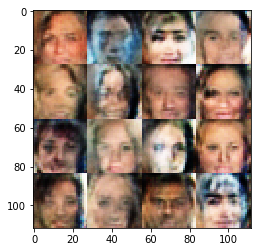

Step 2875/6331 Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.7139
Step 2900/6331 Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.0922
Step 2925/6331 Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6002
Step 2950/6331 Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 1.3212
Step 2975/6331 Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8518
Step 3000/6331 Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.9677


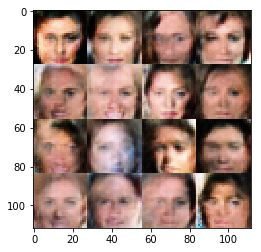

Step 3025/6331 Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6168
Step 3050/6331 Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.9866
Step 3075/6331 Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7985
Step 3100/6331 Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.6779
Step 3125/6331 Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9536
Step 3150/6331 Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9108


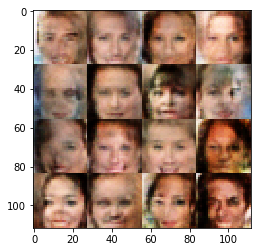

Step 3175/6331 Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.8168
Step 3200/6331 Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9852
Step 3225/6331 Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8139
Step 3250/6331 Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6782
Step 3275/6331 Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6371
Step 3300/6331 Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.1450


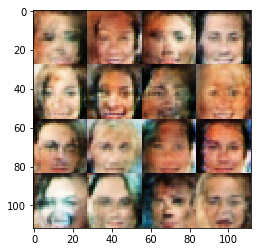

Step 3325/6331 Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 1.1791
Step 3350/6331 Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.4758
Step 3375/6331 Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6051
Step 3400/6331 Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.9630
Step 3425/6331 Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7024
Step 3450/6331 Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8185


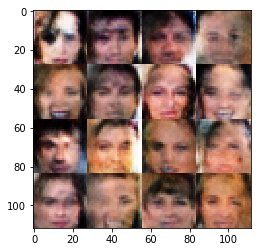

Step 3475/6331 Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.9994
Step 3500/6331 Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9524
Step 3525/6331 Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.9315
Step 3550/6331 Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7784
Step 3575/6331 Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7738
Step 3600/6331 Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.8649


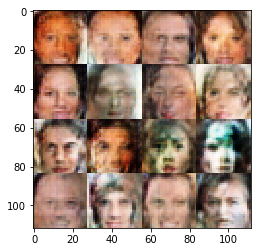

Step 3625/6331 Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 1.0433
Step 3650/6331 Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7700
Step 3675/6331 Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7666
Step 3700/6331 Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.9313
Step 3725/6331 Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7908
Step 3750/6331 Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8599


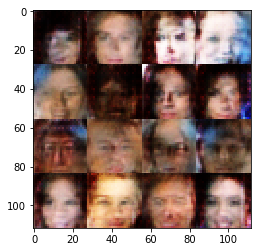

Step 3775/6331 Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.5250
Step 3800/6331 Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.9892
Step 3825/6331 Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7675
Step 3850/6331 Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.2848
Step 3875/6331 Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 1.1013
Step 3900/6331 Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7472


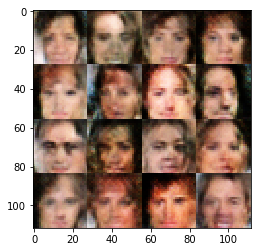

Step 3925/6331 Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 1.2785
Step 3950/6331 Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8367
Step 3975/6331 Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6584
Step 4000/6331 Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.0460
Step 4025/6331 Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8003
Step 4050/6331 Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8236


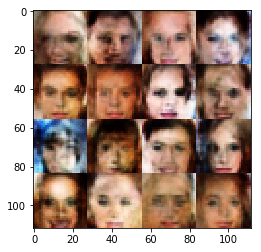

Step 4075/6331 Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.9683
Step 4100/6331 Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.9507
Step 4125/6331 Epoch 1/1... Discriminator Loss: 1.7756... Generator Loss: 0.5062
Step 4150/6331 Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6817
Step 4175/6331 Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.6967
Step 4200/6331 Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9264


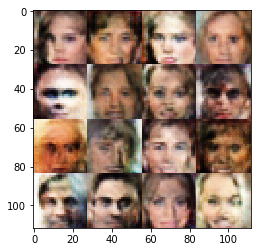

Step 4225/6331 Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7467
Step 4250/6331 Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.6474
Step 4275/6331 Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8039
Step 4300/6331 Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8769
Step 4325/6331 Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.6558
Step 4350/6331 Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8204


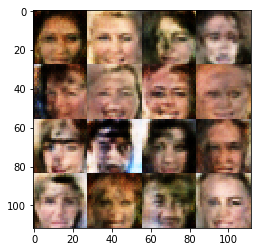

Step 4375/6331 Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9339
Step 4400/6331 Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8129
Step 4425/6331 Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.7436
Step 4450/6331 Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6606
Step 4475/6331 Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.4128
Step 4500/6331 Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9532


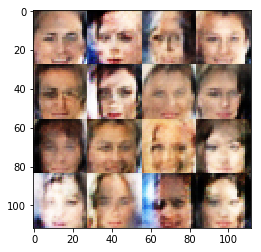

Step 4525/6331 Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.0926
Step 4550/6331 Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.9076
Step 4575/6331 Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.0390
Step 4600/6331 Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.9441
Step 4625/6331 Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 1.1527
Step 4650/6331 Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.0085


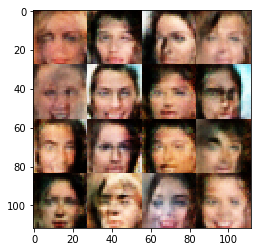

Step 4675/6331 Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8936
Step 4700/6331 Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8094
Step 4725/6331 Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9617
Step 4750/6331 Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.1213
Step 4775/6331 Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.9951
Step 4800/6331 Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 1.0743


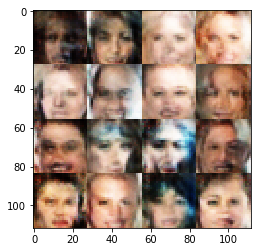

Step 4825/6331 Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7873
Step 4850/6331 Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.9177
Step 4875/6331 Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.7351
Step 4900/6331 Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8765
Step 4925/6331 Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.9570
Step 4950/6331 Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7442


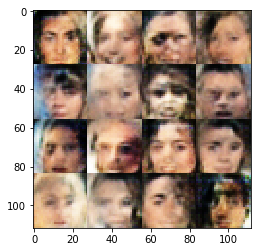

Step 4975/6331 Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9401
Step 5000/6331 Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7852
Step 5025/6331 Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.6244
Step 5050/6331 Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.7862
Step 5075/6331 Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7547
Step 5100/6331 Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8610


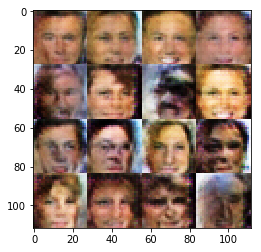

Step 5125/6331 Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.8553
Step 5150/6331 Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.9175
Step 5175/6331 Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.9165
Step 5200/6331 Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.7392
Step 5225/6331 Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.8886
Step 5250/6331 Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.0339


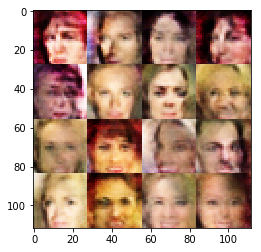

Step 5275/6331 Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7473
Step 5300/6331 Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8048
Step 5325/6331 Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8109
Step 5350/6331 Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.9745
Step 5375/6331 Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7452
Step 5400/6331 Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.9319


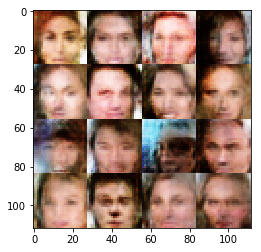

Step 5425/6331 Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.5703
Step 5450/6331 Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.9222
Step 5475/6331 Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0208
Step 5500/6331 Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7882
Step 5525/6331 Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.8389
Step 5550/6331 Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.9342


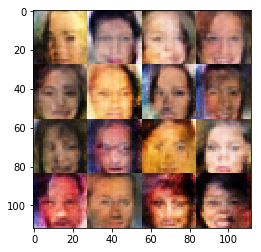

Step 5575/6331 Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6139
Step 5600/6331 Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.7743
Step 5625/6331 Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 1.0573
Step 5650/6331 Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 1.1629
Step 5675/6331 Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7416
Step 5700/6331 Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.8343


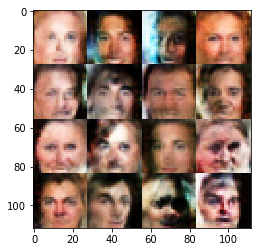

Step 5725/6331 Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7914
Step 5750/6331 Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6452
Step 5775/6331 Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8429
Step 5800/6331 Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.9102
Step 5825/6331 Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8760
Step 5850/6331 Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8237


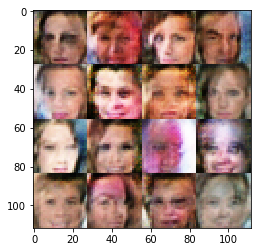

Step 5875/6331 Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0031
Step 5900/6331 Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.7541
Step 5925/6331 Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.9193
Step 5950/6331 Epoch 1/1... Discriminator Loss: 1.8301... Generator Loss: 0.5375
Step 5975/6331 Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7767
Step 6000/6331 Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7256


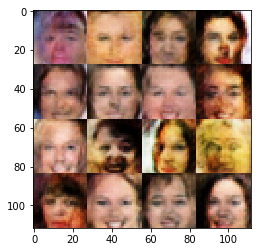

Step 6025/6331 Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8939
Step 6050/6331 Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.8305
Step 6075/6331 Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8523
Step 6100/6331 Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.9047
Step 6125/6331 Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8557
Step 6150/6331 Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7535


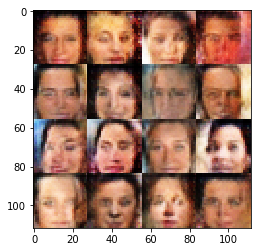

Step 6175/6331 Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8192
Step 6200/6331 Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.8081
Step 6225/6331 Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6445
Step 6250/6331 Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8928
Step 6275/6331 Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.8871
Step 6300/6331 Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7197


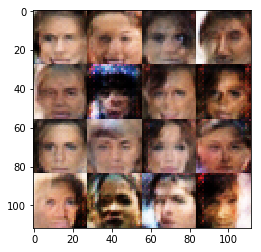

Step 6325/6331 Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.7775
Final Samples:


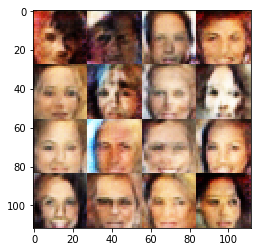

In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005 #0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

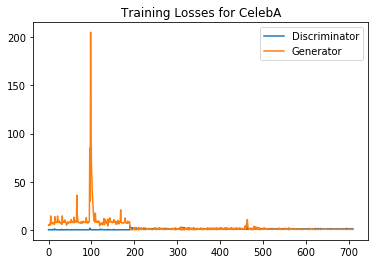

In [26]:
fig, ax = plt.subplots()
nplosses = np.array(losses)
plt.plot(nplosses.T[0], label='Discriminator')
plt.plot(nplosses.T[1], label='Generator')
plt.title("Training Losses for CelebA")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.